## Normalize fields from sample of 1000

In [2]:
import pandas as pd
import json

In [3]:
# Load and convert to DataFrame
with open('extracted_amounts_sample_1000_without_text.json', 'r') as f:
    df = pd.DataFrame(json.load(f))

# Quick overview
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (872, 7)
Columns: ['NAID', 'naraURL', 'title', 'pageObjectId', 'pageURL', 'file_cat', 'extracted_pension_amount']


,NAID,naraURL,title,pageObjectId,pageURL,file_cat,extracted_pension_amount
0,111708949,https://catalog.archives.gov/id/111708949,Revolutionary War Pension and Bounty Land Warr...,111708987,https://s3.amazonaws.com/NARAprodstorage/lz/mi...,widow,"{'applicant_name': 'Eunice Wilder', 'applicant..."
1,196100358,https://catalog.archives.gov/id/196100358,Revolutionary War Pension and Bounty Land Warr...,196100360,https://s3.amazonaws.com/NARAprodstorage/lz/mi...,soldier,"{'applicant_name': 'George Keller', 'applicant..."
2,111503547,https://catalog.archives.gov/id/111503547,Revolutionary War Pension and Bounty Land Warr...,111503552,https://s3.amazonaws.com/NARAprodstorage/lz/mi...,widow,"{'applicant_name': 'Mildred Hart', 'applicant_..."
3,54362674,https://catalog.archives.gov/id/54362674,Revolutionary War Pension and Bounty Land Warr...,54362689,https://s3.amazonaws.com/NARAprodstorage/opast...,widow,"{'applicant_name': 'Mary Date', 'applicant_typ..."
4,54330151,https://catalog.archives.gov/id/54330151,Revolutionary War Pension and Bounty Land Warr...,54330216,https://s3.amazonaws.com/NARAprodstorage/opast...,widow,"{'applicant_name': 'John Crawford', 'applicant..."


In [4]:
percent_success = len(df) / 1000 * 100
print(f"Percent success: {percent_success}%")


Percent success: 87.2%


#### frequencies

In [5]:
# Extract 'pension_frequency' values from the dictionaries, handling None values and missing keys
pension_frequency_values = df['extracted_pension_amount'].apply(
    lambda x: x.get('pension_frequency') if isinstance(x, dict) else None
)

# Count the occurrences of each unique pension_frequency value
pension_frequency_counts = pension_frequency_values.value_counts(dropna=False)

print("Counts of unique 'pension_frequency' values:")
# Iterate and print all unique values and their counts
for frequency, count in pension_frequency_counts.items():
    print(f"{frequency}: {count}")

Counts of unique 'pension_frequency' values:
per annum: 440
annual: 171
per month: 158
None: 28
per an: 13
semi-annual: 9
per ann: 8
semi-annually: 8
per Annum: 6
semiannual: 4
per anum: 3
null: 3
semi-anl.: 3
per ann.: 3
per mo: 2
semi annually: 1
per An.: 1
per Lennum: 1
per burn: 1
per months: 1
per An:: 1
semi-anl: 1
per anm: 1
per year: 1
per month annum: 1
per tum: 1
per annund: 1
per An: 1


In [10]:
def normalize_pension_frequency(freq):
    """
    Normalize pension frequency values to 'annual', 'monthly', or 'semi-annual'
    """
    if pd.isna(freq) or freq is None or str(freq).lower().strip() in ['null', 'none']:
        return 'unknown'
    
    # Convert to lowercase for case-insensitive matching
    freq_lower = str(freq).lower().strip()
    
    # Annual patterns
    annual_patterns = [
        'per annum', 'annual', 'per an', 'per ann', 'per annum', 
        'per anum', 'per ann.', 'per anm', 'per year', 'per annund',
        'per an:', 'per an.', 'per tum', 'per burn', 'per lennum'
    ]
    
    # Monthly patterns
    monthly_patterns = [
        'per month', 'per mo', 'per months', 'per month annum'
    ]
    
    # Semi-annual patterns
    semi_annual_patterns = [
        'semi-annual', 'semi-annually', 'semiannual', 'semi-anl.', 
        'semi-anl', 'semi annually'
    ]
    
    # Check for annual patterns
    for pattern in annual_patterns:
        if pattern in freq_lower:
            return 'annual'
    
    # Check for monthly patterns
    for pattern in monthly_patterns:
        if pattern in freq_lower:
            return 'monthly'
    
    # Check for semi-annual patterns
    for pattern in semi_annual_patterns:
        if pattern in freq_lower:
            return 'semi-annual'
    
    # If no pattern matches, return the original value
    return freq

In [11]:
# Test the function with some examples
test_values = ['per annum', 'annual', 'per month', 'semi-annual', 'per an', 'None', 'per burn', 'random']
for val in test_values:
    print(f"'{val}' -> '{normalize_pension_frequency(val)}'")

'per annum' -> 'annual'
'annual' -> 'annual'
'per month' -> 'monthly'
'semi-annual' -> 'annual'
'per an' -> 'annual'
'None' -> 'unknown'
'per burn' -> 'annual'
'random' -> 'random'


In [12]:
# Apply the normalization function to create a new column
df['payment_frequency'] = df['extracted_pension_amount'].apply(
    lambda x: normalize_pension_frequency(x.get('pension_frequency')) if isinstance(x, dict) else 'unknown'
)

# Check the results
print("Payment frequency counts:")
print(df['payment_frequency'].value_counts(dropna=False))

# Show a few examples
print("\nFirst few rows with the new column:")
df[['NAID', 'extracted_pension_amount', 'payment_frequency']].head()

Payment frequency counts:
payment_frequency
annual         675
monthly        162
unknown         31
semi-annual      4
Name: count, dtype: int64

First few rows with the new column:


,NAID,extracted_pension_amount,payment_frequency
0,111708949,"{'applicant_name': 'Eunice Wilder', 'applicant...",annual
1,196100358,"{'applicant_name': 'George Keller', 'applicant...",annual
2,111503547,"{'applicant_name': 'Mildred Hart', 'applicant_...",annual
3,54362674,"{'applicant_name': 'Mary Date', 'applicant_typ...",annual
4,54330151,"{'applicant_name': 'John Crawford', 'applicant...",annual


#### yearly amount

In [23]:
def calculate_yearly_amount(row):
    """
    Calculate yearly amount based on payment amount and frequency
    """
    # Extract payment amount from extracted_pension_amount
    if isinstance(row['extracted_pension_amount'], dict):
        pension_amount = row['extracted_pension_amount'].get('pension_amount')
    else:
        return None
    
    # Handle None or non-numeric amounts
    if pension_amount is None or pd.isna(pension_amount):
        return None
    
    try:
        amount = float(pension_amount)
    except (ValueError, TypeError):
        return None
    
    # Apply multiplier based on payment frequency
    frequency = row['payment_frequency']
    
    if frequency == 'unknown':
        return None
    elif frequency == 'annual':
        return amount * 1
    elif frequency == 'semi-annual':
        return amount * 2
    elif frequency == 'monthly':
        return amount * 12
    else:  # unknown or other
        return None

In [24]:
# Apply the function to create the yearly_amount column
df['yearly_amount'] = df.apply(calculate_yearly_amount, axis=1)

In [25]:
# Check the results
print("Yearly amount statistics:")
print(df['yearly_amount'].describe())

# Show some examples
print("\nFirst few rows with yearly amounts:")
df[['NAID', 'payment_frequency', 'yearly_amount']].head(10)

Yearly amount statistics:
count      838.000000
mean       133.096021
std       1042.036960
min          2.000000
25%         33.505000
50%         80.000000
75%         96.000000
max      28932.000000
Name: yearly_amount, dtype: float64

First few rows with yearly amounts:


,NAID,payment_frequency,yearly_amount
0,111708949,annual,30.00
1,196100358,annual,60.00
2,111503547,annual,26.10
3,54362674,annual,44.00
4,54330151,annual,80.00
5,54583887,annual,30.44
6,196090855,annual,100.00
7,144329024,annual,80.00
8,54329801,monthly,96.00
9,196274477,annual,160.00


In [31]:
# # Show counts for each unique value in yearly_amount
# print("Counts of unique yearly_amount values:")
yearly_amount_counts = df['yearly_amount'].value_counts(dropna=False)
# print(yearly_amount_counts)

# # # If you want to see them sorted by value (ascending)
# # print("\nSorted by amount (ascending):")
# # print(yearly_amount_counts.sort_index())

# If you want to see the top 20 most common amounts
print("\nTop 50 most common yearly amounts:")
print(yearly_amount_counts.head(50))


Top 50 most common yearly amounts:
yearly_amount
96.00     163
80.00     118
20.00      41
NaN        34
40.00      28
30.00      28
26.66      23
240.00     21
60.00      17
100.00     16
50.00      16
120.00     16
23.33      15
33.33      10
43.33       9
70.00       6
46.66       6
36.66       6
88.00       6
48.00       6
480.00      6
8.00        5
53.33       5
35.00       4
320.00      4
25.00       4
33.00       3
72.00       3
600.00      3
400.00      3
160.00      3
36.00       3
90.00       3
29.00       3
28.00       3
76.00       2
31.55       2
25.66       2
76.66       2
2.00        2
30.44       2
81.00       2
180.00      2
42.00       2
91.66       2
46.00       2
26.00       2
63.00       2
66.66       2
24.44       2
Name: count, dtype: int64


## get date

In [32]:
# Extract date fields into separate columns
df['pension_act_date'] = df['extracted_pension_amount'].apply(
    lambda x: x.get('pension_act') if isinstance(x, dict) else None
)

df['issued_date'] = df['extracted_pension_amount'].apply(
    lambda x: x.get('issued_date') if isinstance(x, dict) else None
)

df['allowance_start_date'] = df['extracted_pension_amount'].apply(
    lambda x: x.get('allowance_start_date') if isinstance(x, dict) else None
)

# Check the results
print("Date columns created:")
print(f"pension_act_date: {df['pension_act_date'].notna().sum()} non-null values")
print(f"issued_date: {df['issued_date'].notna().sum()} non-null values")
print(f"allowance_start_date: {df['allowance_start_date'].notna().sum()} non-null values")

# Show some examples
print("\nSample of date data:")
df[['NAID', 'pension_act_date', 'issued_date', 'allowance_start_date']].head(10)

Date columns created:
pension_act_date: 770 non-null values
issued_date: 545 non-null values
allowance_start_date: 637 non-null values

Sample of date data:


,NAID,pension_act_date,issued_date,allowance_start_date
0,111708949,07/07/1838,07/08/1846,03/04/1836
1,196100358,06/07/1832,05/10/1831,03/04/1831
2,111503547,07/07/1838,None,09/04/1851
3,54362674,07/07/1838,04/04/1836,03/04/1836
4,54330151,06/07/1832,None,None
5,54583887,02/02/1848,None,03/04/1848
6,196090855,07/07/1828,10/10/1838,03/04/1836
7,144329024,07/04/1836,03/12/1839,None
8,54329801,None,09/22/1818,04/20/1818
9,196274477,07/05/1832,None,None


In [33]:
# Convert to datetime (handles various date formats)
from datetime import datetime

def parse_date(date_str):
    if pd.isna(date_str) or date_str is None:
        return None
    try:
        # Handle MM/DD/YYYY format
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except:
        try:
            # Try other common formats
            return pd.to_datetime(date_str)
        except:
            return None

# Apply date parsing
df['pension_act_date_parsed'] = df['pension_act_date'].apply(parse_date)
df['issued_date_parsed'] = df['issued_date'].apply(parse_date)
df['allowance_start_date_parsed'] = df['allowance_start_date'].apply(parse_date)

In [34]:
# Show some examples
print("\nSample of date data:")
df[['NAID', 'pension_act_date', 'issued_date', 'allowance_start_date']].head(40)


Sample of date data:


,NAID,pension_act_date,issued_date,allowance_start_date
0,111708949,07/07/1838,07/08/1846,03/04/1836
1,196100358,06/07/1832,05/10/1831,03/04/1831
2,111503547,07/07/1838,None,09/04/1851
3,54362674,07/07/1838,04/04/1836,03/04/1836
4,54330151,06/07/1832,None,None
5,54583887,02/02/1848,None,03/04/1848
6,196090855,07/07/1828,10/10/1838,03/04/1836
7,144329024,07/04/1836,03/12/1839,None
8,54329801,None,09/22/1818,04/20/1818
9,196274477,07/05/1832,None,None


In [35]:
# Filter to rows that have yearly_amount values (not NaN)
rows_with_yearly_amount = df[df['yearly_amount'].notna()]

print(f"Total rows with yearly_amount: {len(rows_with_yearly_amount)}")
print(f"Total rows in dataset: {len(df)}")
print(f"Percentage with yearly_amount: {len(rows_with_yearly_amount)/len(df)*100:.1f}%")

print("\nFor rows WITH yearly_amount values:")
print(f"pension_act_date: {rows_with_yearly_amount['pension_act_date'].notna().sum()} / {len(rows_with_yearly_amount)} = {rows_with_yearly_amount['pension_act_date'].notna().sum()/len(rows_with_yearly_amount)*100:.1f}%")
print(f"issued_date: {rows_with_yearly_amount['issued_date'].notna().sum()} / {len(rows_with_yearly_amount)} = {rows_with_yearly_amount['issued_date'].notna().sum()/len(rows_with_yearly_amount)*100:.1f}%")
print(f"allowance_start_date: {rows_with_yearly_amount['allowance_start_date'].notna().sum()} / {len(rows_with_yearly_amount)} = {rows_with_yearly_amount['allowance_start_date'].notna().sum()/len(rows_with_yearly_amount)*100:.1f}%")

# Show a summary table
date_summary = pd.DataFrame({
    'Date_Column': ['pension_act_date', 'issued_date', 'allowance_start_date'],
    'Count_With_Values': [
        rows_with_yearly_amount['pension_act_date'].notna().sum(),
        rows_with_yearly_amount['issued_date'].notna().sum(),
        rows_with_yearly_amount['allowance_start_date'].notna().sum()
    ],
    'Percentage': [
        rows_with_yearly_amount['pension_act_date'].notna().sum()/len(rows_with_yearly_amount)*100,
        rows_with_yearly_amount['issued_date'].notna().sum()/len(rows_with_yearly_amount)*100,
        rows_with_yearly_amount['allowance_start_date'].notna().sum()/len(rows_with_yearly_amount)*100
    ]
})

print("\nSummary table:")
print(date_summary)

Total rows with yearly_amount: 838
Total rows in dataset: 872
Percentage with yearly_amount: 96.1%

For rows WITH yearly_amount values:
pension_act_date: 743 / 838 = 88.7%
issued_date: 533 / 838 = 63.6%
allowance_start_date: 623 / 838 = 74.3%

Summary table:
            Date_Column  Count_With_Values  Percentage
0      pension_act_date                743   88.663484
1           issued_date                533   63.603819
2  allowance_start_date                623   74.343675


In [38]:
# Count unique values in pension_act_date
# print("Counts of unique pension_act_date values:")
pension_act_counts = df['pension_act_date'].value_counts(dropna=False)
# print(pension_act_counts)

# If you want to see them sorted by date
# print("\nSorted by date:")
# print(pension_act_counts.sort_index())

# Show just the top 20 most common dates
print("\nTop 20 most common pension_act_date values:")
print(pension_act_counts.head(20))


Top 20 most common pension_act_date values:
pension_act_date
06/07/1832    251
03/18/1818    126
None          102
07/07/1838     94
03/03/1843     69
02/02/1848     49
02/03/1853     32
07/04/1836     29
06/17/1844     17
07/29/1848      9
04/06/1838      4
07/27/1868      4
03/03/1855      4
06/18/1832      4
03/18/1848      3
07/1838         3
06/07/1838      3
06/1832         2
05/15/1828      2
07/18/1838      2
Name: count, dtype: int64


In [43]:
# Load the timeline data
import json

timeline_path = '/Users/oliviakasmin/Library/Mobile Documents/com~apple~CloudDocs/Documents/Data_Visualization_Parsons/Year_2/MajorStudio1/Code/parsons-major-studio-1-fall-2025/projects/quantitative/historical_research/timeline.json'

with open(timeline_path, 'r') as f:
    timeline = json.load(f)

# Create a mapping of known act dates
known_acts = {}
for event in timeline:
    if event['date'] != 'archival-category':  # Skip non-date entries
        known_acts[event['date']] = {
            'context': event['historical_context'],
            'categories': event['relevant_categories'],
            'main_takeaway': event['main_takeaway']
        }

# Convert your pension_act_date to match timeline format (YYYY-MM-DD)
def convert_to_timeline_format(date_str):
    if pd.isna(date_str) or date_str is None:
        return None
    try:
        # Convert MM/DD/YYYY to YYYY-MM-DD
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d')
    except:
        return None

# Add converted date column
df['pension_act_date_formatted'] = df['pension_act_date'].apply(convert_to_timeline_format)

# Check which dates match known acts
df['matches_known_act'] = df['pension_act_date_formatted'].isin(known_acts.keys())

# Show comparison
print("Comparison of pension act dates to known timeline:")
print(f"Total pension act dates: {df['pension_act_date'].notna().sum()}")
print(f"Dates matching known acts: {df['matches_known_act'].sum()}")
print(f"Percentage matching: {df['matches_known_act'].sum() / df['pension_act_date'].notna().sum() * 100:.1f}%")

# Show which known acts appear in your data
print("\nKnown acts found in your data:")
matched_dates = df[df['matches_known_act']]['pension_act_date_formatted'].value_counts()
for date, count in matched_dates.items():
    if date in known_acts:
        print(f"\n{date} ({count} occurrences):")
        print(f"  Context: {known_acts[date]['context']}")
        print(f"  Categories: {known_acts[date]['categories']}")

# Show unmatched dates
print("\nUnmatched dates in your data:")
unmatched = df[df['pension_act_date'].notna() & ~df['matches_known_act']]['pension_act_date'].value_counts()
print(unmatched.head(10))

Comparison of pension act dates to known timeline:
Total pension act dates: 770
Dates matching known acts: 576
Percentage matching: 74.8%

Known acts found in your data:

1832-06-07 (251 occurrences):
  Context: Act of 1832. The last and most liberal of the service-pension acts; covered nearly all surviving veterans with at least 6 months’ service (partial) or 2 years (full).
  Categories: Soldier

1818-03-18 (126 occurrences):
  Context: Act of 1818. The act of March 18, 1818, granted pensions to every officer, noncommissioned officer, musician, and private soldier who had served in the Continental Line for 9 months or more.
  Categories: Soldier||Rejected

1838-07-07 (94 occurrences):
  Context: Extended widow eligibility to marriages before January 2, 1800.
  Categories: Widow

1843-03-03 (69 occurrences):
  Context: Extended provisions to widows who married before January 1, 1800 and were living with the veteran at his death.
  Categories: Widow

1836-07-04 (29 occurrences):
  Cont

In [47]:
# First, extract the applicant_type from the extracted_pension_amount dictionary
df['applicant_type'] = df['extracted_pension_amount'].apply(
    lambda x: x.get('applicant_type') if isinstance(x, dict) else None
)

# Filter to widow applications only
widow_df = df[df['applicant_type'] == 'widow']

# Show counts of unique pension act dates for widows
print("Counts of unique pension act dates for widow applications:")
widow_act_dates = widow_df['pension_act_date'].value_counts(dropna=False)
print(widow_act_dates)

# Show summary
print(f"\nTotal widow applications: {len(widow_df)}")
print(f"Widow applications with pension act dates: {widow_df['pension_act_date'].notna().sum()}")
print(f"Unique pension act dates for widows: {len(widow_act_dates)}")

# Show top 20 most common dates
print("\nTop 20 most common pension act dates for widows:")
print(widow_act_dates.head(20))

Counts of unique pension act dates for widow applications:
pension_act_date
07/07/1838                          87
03/03/1843                          68
02/02/1848                          48
None                                47
06/07/1832                          32
02/03/1853                          32
07/04/1836                          28
06/17/1844                          17
07/29/1848                           9
03/18/1818                           5
07/27/1868                           4
07/1838                              3
06/18/1832                           3
03/03/1855                           3
02/18/1848                           2
06/02/1848                           2
02/03/1883                           1
07/07/1836                           1
02/24/1832                           1
07/20/1848                           1
07/04/1834                           1
03/02/1855                           1
07/04/1936                           1
02/01/1853                 

In [48]:
# First, let's get the known act dates from the timeline
known_act_dates = set()
for event in timeline:
    if event['date'] != 'archival-category':  # Skip non-date entries
        known_act_dates.add(event['date'])

# Function to create the object with annual_amount and pension_act
def create_pension_object(row):
    # Check if we have both yearly_amount and a valid pension_act_date
    if pd.isna(row['yearly_amount']) or pd.isna(row['pension_act_date_formatted']):
        return None
    
    # Check if the pension_act_date matches a known act date
    if row['pension_act_date_formatted'] not in known_act_dates:
        return None
    
    # If both conditions are met, return the object
    return {
        'annual_amount': row['yearly_amount'],
        'pension_act': row['pension_act_date_formatted']
    }

# Apply the function to create the new column
df['pension_data'] = df.apply(create_pension_object, axis=1)

# Check the results
print("Pension data column created:")
print(f"Rows with pension_data: {df['pension_data'].notna().sum()}")
print(f"Rows without pension_data: {df['pension_data'].isna().sum()}")

# Show some examples
print("\nSample of rows with pension_data:")
sample_with_data = df[df['pension_data'].notna()].head(10)
for idx, row in sample_with_data.iterrows():
    print(f"NAID: {row['NAID']}, Pension Data: {row['pension_data']}")

# Show summary by applicant type
print("\nPension data by applicant type:")
pension_by_type = df.groupby('applicant_type')['pension_data'].apply(lambda x: x.notna().sum())
print(pension_by_type)

Pension data column created:
Rows with pension_data: 559
Rows without pension_data: 313

Sample of rows with pension_data:
NAID: 111708949, Pension Data: {'annual_amount': 30.0, 'pension_act': '1838-07-07'}
NAID: 196100358, Pension Data: {'annual_amount': 60.0, 'pension_act': '1832-06-07'}
NAID: 111503547, Pension Data: {'annual_amount': 26.1, 'pension_act': '1838-07-07'}
NAID: 54362674, Pension Data: {'annual_amount': 44.0, 'pension_act': '1838-07-07'}
NAID: 54330151, Pension Data: {'annual_amount': 80.0, 'pension_act': '1832-06-07'}
NAID: 144329024, Pension Data: {'annual_amount': 80.0, 'pension_act': '1836-07-04'}
NAID: 54629793, Pension Data: {'annual_amount': 31.55, 'pension_act': '1832-06-07'}
NAID: 196445174, Pension Data: {'annual_amount': 80.4, 'pension_act': '1838-07-07'}
NAID: 54342715, Pension Data: {'annual_amount': 33.33, 'pension_act': '1832-06-07'}
NAID: 196657930, Pension Data: {'annual_amount': 40.0, 'pension_act': '1836-07-04'}

Pension data by applicant type:
applic

In [ ]:
# LLM success rate
percent_success = len(df) / 1000 * 100
print(f"Percent success: {percent_success}%")


# Frequency success rate - number of rows with successful normalized frequency / len(df)


# Yearly amount success rate - number of rows with successful yearly amount / len(df)


# Valid pension act date success rate - number of rows with valid historical pension act date / len(df)


# Amount + Valid pension act date success rate - number of rows with successful yearly amount and valid historical pension act date / len(df)

In [60]:
# LLM success rate
percent_success = len(df) / 1000 * 100
print(f"LLM Success Rate: {percent_success:.1f}% ({len(df)} out of 1000 samples)")

# Frequency success rate - number of rows with successful normalized frequency / len(df)
frequency_success = len(df[df['payment_frequency'].isin(['annual', 'monthly', 'semi-annual'])])
frequency_success_rate = frequency_success / len(df) * 100
print(f"Frequency Success Rate: {frequency_success_rate:.1f}% ({frequency_success} out of {len(df)} rows)")

# Yearly amount success rate - number of rows with successful yearly amount / len(df)
yearly_amount_success = len(df[df['yearly_amount'].notna()])
yearly_amount_success_rate = yearly_amount_success / len(df) * 100
print(f"Yearly Amount Success Rate: {yearly_amount_success_rate:.1f}% ({yearly_amount_success} out of {len(df)} rows)")

# Date availability rates
pension_act_date_success = len(df[df['pension_act_date'].notna()])
pension_act_date_rate = pension_act_date_success / len(df) * 100
print(f"Pension Act Date Success Rate: {pension_act_date_rate:.1f}% ({pension_act_date_success} out of {len(df)} rows)")

issued_date_success = len(df[df['issued_date'].notna()])
issued_date_rate = issued_date_success / len(df) * 100
# print(f"Issued Date Success Rate: {issued_date_rate:.1f}% ({issued_date_success} out of {len(df)} rows)")

allowance_start_date_success = len(df[df['allowance_start_date'].notna()])
allowance_start_date_rate = allowance_start_date_success / len(df) * 100
# print(f"Allowance Start Date Success Rate: {allowance_start_date_rate:.1f}% ({allowance_start_date_success} out of {len(df)} rows)")

# Valid pension act date success rate - number of rows with valid historical pension act date / len(df)
valid_act_date_success = len(df[df['matches_known_act'] == True])
valid_act_date_success_rate = valid_act_date_success / len(df) * 100
print(f"Valid Historical Act Date Success Rate: {valid_act_date_success_rate:.1f}% ({valid_act_date_success} out of {len(df)} rows)")

# Amount + Valid pension act date success rate - number of rows with successful yearly amount and valid historical pension act date / len(df)
pension_data_success = len(df[df['pension_data'].notna()])
pension_data_success_rate = pension_data_success / len(df) * 100
print(f"Pension Data Success Rate: {pension_data_success_rate:.1f}% ({pension_data_success} out of {len(df)} rows)")

# Show the pipeline progression
print("\n" + "="*60)
print("DATA PROCESSING PIPELINE SUMMARY")
print("="*60)
print(f"1. Starting Dataset: 1,000 samples")
print(f"2. LLM Processing: {len(df):,} samples ({percent_success:.1f}%)")
print(f"3. Frequency Normalization: {frequency_success:,} samples ({frequency_success_rate:.1f}%)")
print(f"4. Yearly Amount Calculation: {yearly_amount_success:,} samples ({yearly_amount_success_rate:.1f}%)")
print(f"5. Pension Act Date Available: {pension_act_date_success:,} samples ({pension_act_date_rate:.1f}%)")
print(f"6. Issued Date Available: {issued_date_success:,} samples ({issued_date_rate:.1f}%)")
print(f"7. Allowance Start Date Available: {allowance_start_date_success:,} samples ({allowance_start_date_rate:.1f}%)")
print(f"8. Valid Historical Act Dates: {valid_act_date_success:,} samples ({valid_act_date_success_rate:.1f}%)")
print(f"9. Final Pension Data Objects: {pension_data_success:,} samples ({pension_data_success_rate:.1f}%)")
print("="*60)

# Show what we lost at each step
print("\nDATA LOSS AT EACH STEP:")
print(f"LLM Processing Loss: {1000 - len(df):,} samples ({100 - percent_success:.1f}%)")
print(f"Frequency Normalization Loss: {len(df) - frequency_success:,} samples ({100 - frequency_success_rate:.1f}%)")
print(f"Yearly Amount Calculation Loss: {frequency_success - yearly_amount_success:,} samples ({frequency_success_rate - yearly_amount_success_rate:.1f}%)")
print(f"Valid Act Date Loss: {yearly_amount_success - valid_act_date_success:,} samples ({yearly_amount_success_rate - valid_act_date_success_rate:.1f}%)")
print(f"Final Pension Data Loss: {valid_act_date_success - pension_data_success:,} samples ({valid_act_date_success_rate - pension_data_success_rate:.1f}%)")

# Show cumulative success rate
print(f"\nCumulative Success Rate: {pension_data_success/1000*100:.1f}% (from 1,000 to {pension_data_success} final samples)")

# Show date availability summary
print(f"\nDATE AVAILABILITY SUMMARY:")
print(f"Pension Act Date: {pension_act_date_rate:.1f}% available")
print(f"Issued Date: {issued_date_rate:.1f}% available") 
print(f"Allowance Start Date: {allowance_start_date_rate:.1f}% available")
print(f"Valid Historical Act Dates: {valid_act_date_success_rate:.1f}% match known acts")

LLM Success Rate: 87.2% (872 out of 1000 samples)
Frequency Success Rate: 96.4% (841 out of 872 rows)
Yearly Amount Success Rate: 96.1% (838 out of 872 rows)
Pension Act Date Success Rate: 88.3% (770 out of 872 rows)
Valid Historical Act Date Success Rate: 66.1% (576 out of 872 rows)
Pension Data Success Rate: 64.1% (559 out of 872 rows)

DATA PROCESSING PIPELINE SUMMARY
1. Starting Dataset: 1,000 samples
2. LLM Processing: 872 samples (87.2%)
3. Frequency Normalization: 841 samples (96.4%)
4. Yearly Amount Calculation: 838 samples (96.1%)
5. Pension Act Date Available: 770 samples (88.3%)
6. Issued Date Available: 545 samples (62.5%)
7. Allowance Start Date Available: 637 samples (73.1%)
8. Valid Historical Act Dates: 576 samples (66.1%)
9. Final Pension Data Objects: 559 samples (64.1%)

DATA LOSS AT EACH STEP:
LLM Processing Loss: 128 samples (12.8%)
Frequency Normalization Loss: 31 samples (3.6%)
Yearly Amount Calculation Loss: 3 samples (0.3%)
Valid Act Date Loss: 262 samples (30.

In [61]:
# Filter to rows with pension_data (valid annual amounts and pension act dates)
pension_data_df = df[df['pension_data'].notna()].copy()

# Extract the pension act dates and annual amounts
pension_data_df['pension_act_date'] = pension_data_df['pension_data'].apply(lambda x: x['pension_act'])
pension_data_df['annual_amount'] = pension_data_df['pension_data'].apply(lambda x: x['annual_amount'])

# Convert pension act dates to datetime
pension_data_df['pension_act_datetime'] = pd.to_datetime(pension_data_df['pension_act_date'])

# Sort by date
pension_data_df = pension_data_df.sort_values('pension_act_datetime')

In [55]:
# Check the 1832 data specifically for widows
print("Checking 1832 widow data:")
print("="*50)

# Filter to 1832 widows
widows_1832 = pension_data_df[
    (pension_data_df['pension_act_date'] == '1832-06-07') & 
    (pension_data_df['applicant_type'] == 'widow')
]

print(f"Number of widows in 1832: {len(widows_1832)}")
print(f"Average amount for widows in 1832: ${widows_1832['annual_amount'].mean():.2f}")
print(f"Min amount: ${widows_1832['annual_amount'].min():.2f}")
print(f"Max amount: ${widows_1832['annual_amount'].max():.2f}")

print("\nIndividual widow amounts in 1832:")
for idx, row in widows_1832.iterrows():
    print(f"NAID: {row['NAID']}, Amount: ${row['annual_amount']:.2f}")

# Also check if there are any outliers
print(f"\nStandard deviation: ${widows_1832['annual_amount'].std():.2f}")

# Check if this seems reasonable historically
print(f"\nHistorical context:")
print(f"Typical pension amounts in 1832 were $20-100 per year")
print(f"Our 1832 widow average: ${widows_1832['annual_amount'].mean():.2f}")
print(f"This is {widows_1832['annual_amount'].mean() / 50:.1f}x higher than typical amounts")

# Check if there might be a data issue
print(f"\nChecking for potential data issues:")
print(f"Any amounts over $500: {len(widows_1832[widows_1832['annual_amount'] > 500])}")
print(f"Any amounts over $1000: {len(widows_1832[widows_1832['annual_amount'] > 1000])}")

Checking 1832 widow data:
Number of widows in 1832: 27
Average amount for widows in 1832: $1186.07
Min amount: $23.33
Max amount: $28932.00

Individual widow amounts in 1832:
NAID: 54062090, Amount: $36.66
NAID: 144320229, Amount: $23.33
NAID: 53952117, Amount: $143.33
NAID: 144267794, Amount: $600.00
NAID: 144279879, Amount: $25.66
NAID: 111658015, Amount: $100.00
NAID: 111504870, Amount: $33.11
NAID: 196428123, Amount: $50.00
NAID: 54326136, Amount: $77.54
NAID: 144079143, Amount: $100.00
NAID: 196114873, Amount: $30.00
NAID: 54257106, Amount: $40.33
NAID: 54462732, Amount: $90.00
NAID: 54524270, Amount: $50.00
NAID: 54903118, Amount: $320.00
NAID: 54560004, Amount: $28932.00
NAID: 53999005, Amount: $80.00
NAID: 111493031, Amount: $31.32
NAID: 54880722, Amount: $93.44
NAID: 54956840, Amount: $60.00
NAID: 111469443, Amount: $58.21
NAID: 54953589, Amount: $80.00
NAID: 144115568, Amount: $54.00
NAID: 144330459, Amount: $355.00
NAID: 196675041, Amount: $100.00
NAID: 54556014, Amount: $60

In [56]:
# Check the outlier case
outlier_naid = '54560004'
outlier_row = pension_data_df[pension_data_df['NAID'] == outlier_naid]
print(f"Outlier case details:")
print(f"NAID: {outlier_row['NAID'].iloc[0]}")
print(f"Annual amount: ${outlier_row['annual_amount'].iloc[0]:.2f}")
print(f"Original pension amount: {outlier_row['extracted_pension_amount'].iloc[0].get('pension_amount', 'N/A')}")
print(f"Payment frequency: {outlier_row['payment_frequency'].iloc[0]}")

# Calculate average without the outlier
widows_1832_clean = widows_1832[widows_1832['NAID'] != outlier_naid]
print(f"\nCleaned 1832 widow data (without outlier):")
print(f"Number of widows: {len(widows_1832_clean)}")
print(f"Average amount: ${widows_1832_clean['annual_amount'].mean():.2f}")
print(f"Min amount: ${widows_1832_clean['annual_amount'].min():.2f}")
print(f"Max amount: ${widows_1832_clean['annual_amount'].max():.2f}")

# Check if there are other outliers in the dataset
print(f"\nChecking for other outliers in the entire dataset:")
high_amounts = pension_data_df[pension_data_df['annual_amount'] > 1000]
print(f"Records with amounts > $1000: {len(high_amounts)}")
if len(high_amounts) > 0:
    print("High amount cases:")
    for idx, row in high_amounts.iterrows():
        print(f"NAID: {row['NAID']}, Amount: ${row['annual_amount']:.2f}, Type: {row['applicant_type']}")

# Suggest a reasonable threshold for outlier detection
print(f"\nSuggested outlier threshold:")
print(f"95th percentile: ${pension_data_df['annual_amount'].quantile(0.95):.2f}")
print(f"99th percentile: ${pension_data_df['annual_amount'].quantile(0.99):.2f}")

Outlier case details:
NAID: 54560004
Annual amount: $28932.00
Original pension amount: 28932
Payment frequency: annual

Cleaned 1832 widow data (without outlier):
Number of widows: 26
Average amount: $118.92
Min amount: $23.33
Max amount: $600.00

Checking for other outliers in the entire dataset:
Records with amounts > $1000: 2
High amount cases:
NAID: 54683119, Amount: $2278.00, Type: soldier
NAID: 54560004, Amount: $28932.00, Type: widow

Suggested outlier threshold:
95th percentile: $240.00
99th percentile: $545.04


In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

Original dataset: 559 records
Cleaned dataset: 557 records
Removed 2 outliers


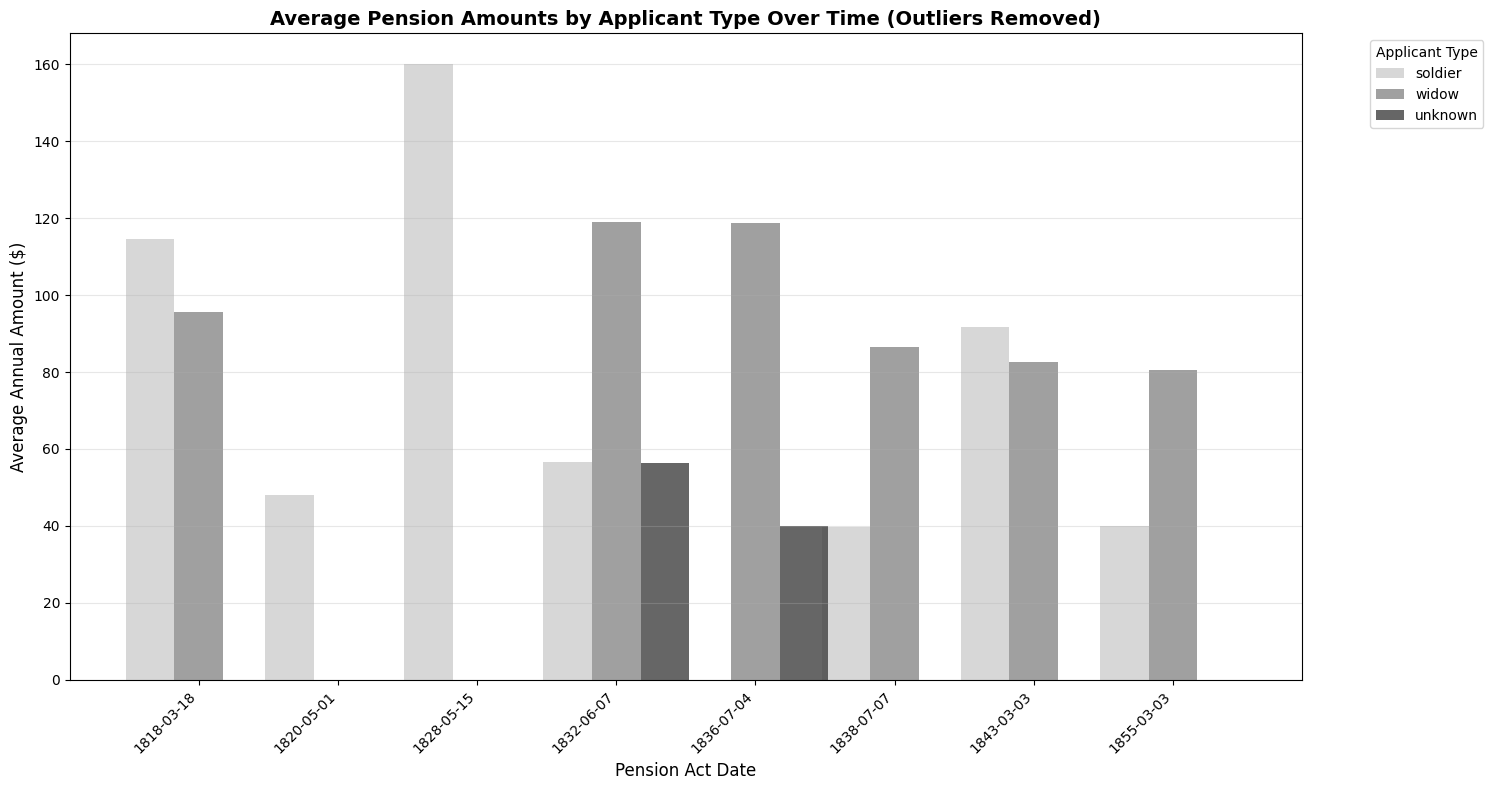


Corrected 1832 widow average: $118.92


In [65]:
# Create cleaned dataset by removing outliers (amounts > $1000)
pension_data_clean = pension_data_df[pension_data_df['annual_amount'] <= 1000].copy()

print(f"Original dataset: {len(pension_data_df)} records")
print(f"Cleaned dataset: {len(pension_data_clean)} records")
print(f"Removed {len(pension_data_df) - len(pension_data_clean)} outliers")

# Recreate the average amounts chart with cleaned data
fig, ax = plt.subplots(figsize=(15, 8))

# Get unique applicant types for cleaned data
applicant_types_clean = pension_data_clean['applicant_type'].dropna().unique()
# Use greyscale colors
colors = plt.cm.Greys(np.linspace(0.3, 0.8, len(applicant_types_clean)))
color_map = dict(zip(applicant_types_clean, colors))

# Group by pension act date and applicant type, calculate average amounts
pivot_data_clean = pension_data_clean.groupby(['pension_act_date', 'applicant_type'])['annual_amount'].mean().unstack(fill_value=0)

# Get the dates for x-axis positioning
dates = pivot_data_clean.index
x_pos = np.arange(len(dates))
width = 0.35

# Create separate bars for each applicant type
for i, applicant_type in enumerate(applicant_types_clean):
    if applicant_type in pivot_data_clean.columns:
        x_positions = x_pos + (i - len(applicant_types_clean)/2 + 0.5) * width
        ax.bar(x_positions, pivot_data_clean[applicant_type], 
               width, label=applicant_type, 
               color=color_map[applicant_type], alpha=0.8)

# Customize the plot
ax.set_xlabel('Pension Act Date', fontsize=12)
ax.set_ylabel('Average Annual Amount ($)', fontsize=12)
ax.set_title('Average Pension Amounts by Applicant Type Over Time (Outliers Removed)', fontsize=14, fontweight='bold')

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, rotation=45, ha='right')

# Add legend
ax.legend(title='Applicant Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Show the corrected 1832 widow average
widows_1832_clean = pension_data_clean[
    (pension_data_clean['pension_act_date'] == '1832-06-07') & 
    (pension_data_clean['applicant_type'] == 'widow')
]
print(f"\nCorrected 1832 widow average: ${widows_1832_clean['annual_amount'].mean():.2f}")

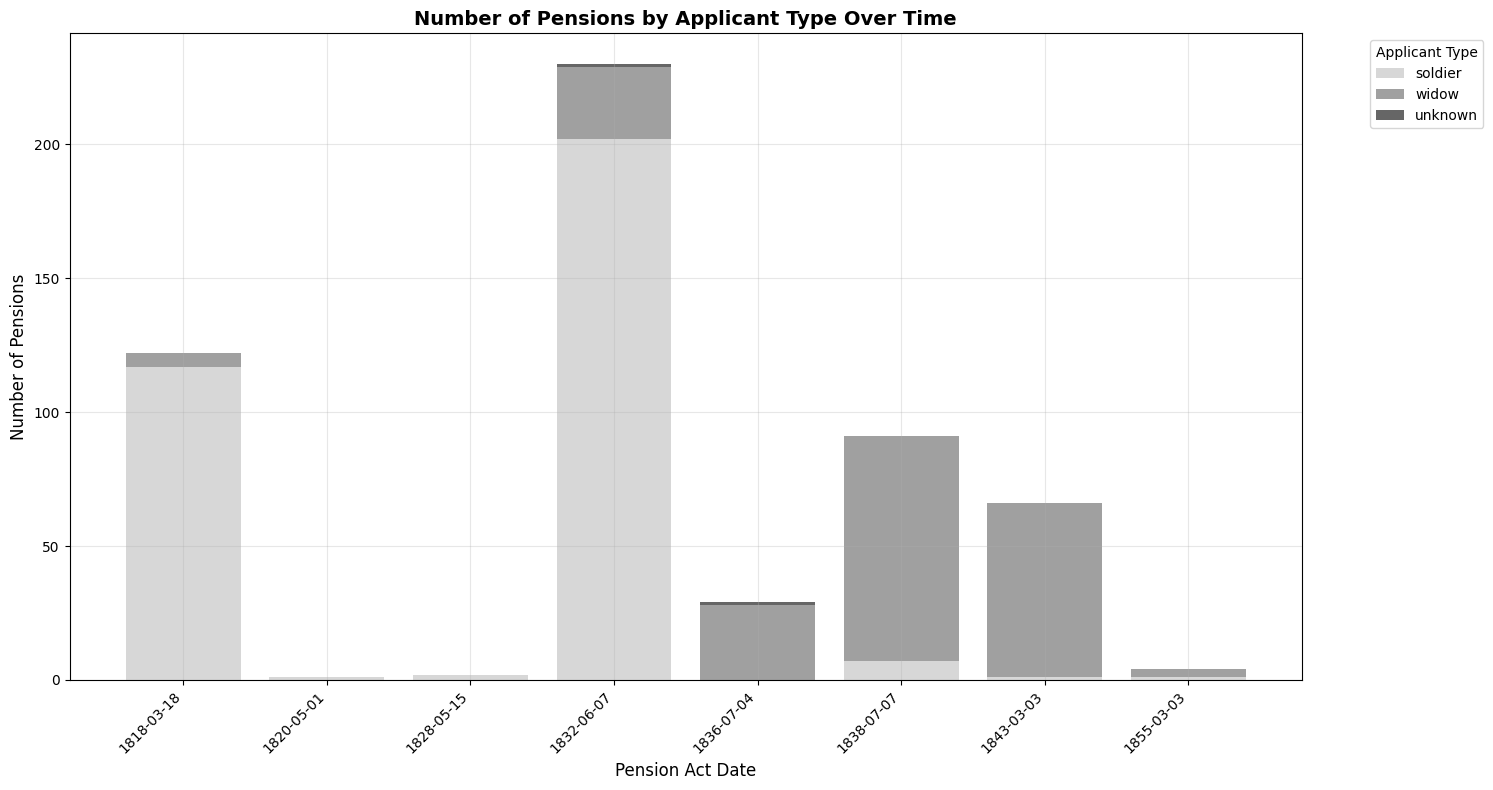

Count Chart Summary:
Total pension data points: 559
Date range: 1818-03-18 to 1855-03-03

Total counts by applicant type:
soldier: 331 pensions
widow: 212 pensions
unknown: 2 pensions

Pivot data (counts by date and applicant type):
applicant_type    soldier  unknown  widow
pension_act_date                         
1818-03-18            117        0      5
1820-05-01              1        0      0
1828-05-15              2        0      0
1832-06-07            202        1     27
1836-07-04              0        1     28
1838-07-07              7        0     84
1843-03-03              1        0     65
1855-03-03              1        0      3


In [66]:
# First, extract the applicant_type from the extracted_pension_amount dictionary
df['applicant_type'] = df['extracted_pension_amount'].apply(
    lambda x: x.get('applicant_type') if isinstance(x, dict) else None
)

# Create a second chart showing counts
fig2, ax2 = plt.subplots(figsize=(15, 8))

# Get unique applicant types and create greyscale color mapping
applicant_types = pension_data_df['applicant_type'].dropna().unique()
colors = plt.cm.Greys(np.linspace(0.3, 0.8, len(applicant_types)))
color_map = dict(zip(applicant_types, colors))

# Group by pension act date and applicant type, count the occurrences
pivot_counts = pension_data_df.groupby(['pension_act_date', 'applicant_type']).size().unstack(fill_value=0)

# Create the stacked bar chart for counts
bottom = np.zeros(len(pivot_counts))
for applicant_type in applicant_types:
    if applicant_type in pivot_counts.columns:
        ax2.bar(pivot_counts.index, pivot_counts[applicant_type], 
                bottom=bottom, label=applicant_type, 
                color=color_map[applicant_type], alpha=0.8)
        bottom += pivot_counts[applicant_type]

# Customize the plot
ax2.set_xlabel('Pension Act Date', fontsize=12)
ax2.set_ylabel('Number of Pensions', fontsize=12)
ax2.set_title('Number of Pensions by Applicant Type Over Time', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax2.legend(title='Applicant Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics for counts
print("Count Chart Summary:")
print(f"Total pension data points: {len(pension_data_df)}")
print(f"Date range: {pension_data_df['pension_act_datetime'].min().strftime('%Y-%m-%d')} to {pension_data_df['pension_act_datetime'].max().strftime('%Y-%m-%d')}")

# Show counts by applicant type
print("\nTotal counts by applicant type:")
for applicant_type in applicant_types:
    if applicant_type in pivot_counts.columns:
        total_count = pension_data_df[pension_data_df['applicant_type'] == applicant_type].shape[0]
        print(f"{applicant_type}: {total_count} pensions")

# Show the pivot data for counts
print("\nPivot data (counts by date and applicant type):")
print(pivot_counts)